In [ ]:
import pandas as pd
import numpy as np
from dateutil import parser
from datetime import timedelta

In [ ]:
#df = pd.read_csv('stops_all.csv', header = None)
#df.columns = ["train_id", "station_id", "arrival_time", "departure_time"]
#df.to_csv('stops_all.csv', index=False)
df = pd.read_csv('stops_all.csv')
train_id_list = df.train_id.unique()

In [ ]:
def timeDiff(time_from, time_to, prev_minutes):
    prev_hours = prev_minutes // 60
    td = parser.parse(time_to) - parser.parse(time_from)
    hours = td.total_seconds() // 3600
    #print(hours)
    #print(hours - prev_hours)
    if hours > 12 :
        #print("-12h")
        td = td - timedelta(hours=12)
    if hours < prev_hours:
        #print("+24h")
        td = td + timedelta(hours=24)
        #print(td)
        #print(td.total_seconds())
    minutes = td.total_seconds() // 60
    return minutes

In [ ]:
timeDiff('16:10', '17:29', 1435)

In [ ]:
def getGraphConnectionListByTrainId(train_id):
    graph_connection_list = []
    df_train = df.loc[df.train_id == train_id].copy()
    for index_from, row_from in df_train.iterrows():
        #if index_from+1 < len(df_train.index):
        prev_minutes = 0
        for index_to, row_to in df_train.loc[index_from+1:,].iterrows():
            travel_time = timeDiff(row_from.departure_time, row_to.arrival_time, prev_minutes)
            graph_connection = (train_id, row_from.station_id, row_from.departure_time, 
                                row_to.station_id, row_to.arrival_time, int(travel_time))
            graph_connection_list.append(graph_connection)
            prev_minutes = travel_time
    return graph_connection_list

In [ ]:
graph_connection_list = []
for train_id in train_id_list: 
    train_graph_connection_list = getGraphConnectionListByTrainId(train_id)
    graph_connection_list.extend(train_graph_connection_list)

In [ ]:
columns = ['train_id', 'from_station_id', 'departure_time', 'to_station_id', 'arrival_time', 'travel_time']
df_graph = pd.DataFrame(graph_connection_list, columns=columns)
df_graph.to_csv('graph_all.csv', index=False)

In [ ]:
#df = pd.read_csv('stations_all.csv', header = None)
#df.columns = ["id", "name"]
#df.to_csv('stations_all.csv', index=False, encoding='utf-8')

#df = pd.read_csv('trains_all.csv', header = None)
#df.columns = ["id", "number", "name", "description","travel_time"]
#df.to_csv('trains_all.csv', index=False, encoding='utf-8')

In [2]:
# Import necessary modules
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nxv
from nxviz import CircosPlot 

In [3]:
df_graph = pd.read_csv('graph_all.csv')
idx = df_graph.groupby(['train_id'])['travel_time'].transform(max) == df_graph['travel_time']
df_graph = df_graph[idx].copy()

In [4]:
df_stations = pd.read_csv('stations_all.csv')

In [5]:
df_graph = pd.merge(df_graph, df_stations, how='inner', left_on='from_station_id', right_on='id')
df_graph = df_graph.rename(columns={'name': 'from_station_name'})
df_graph = pd.merge(df_graph, df_stations, how='inner', left_on='to_station_id', right_on='id')
df_graph = df_graph.rename(columns={'name': 'to_station_name'})

In [6]:
df_graph['travel_time'] = df_graph['travel_time'].astype(float)

In [7]:
G = nx.from_pandas_dataframe(df_graph, source='from_station_name', target='to_station_name', 
                            edge_attr=['train_id', 'from_station_name', 'to_station_name', 'departure_time', 'arrival_time', 'travel_time'], 
                            create_using=nx.MultiDiGraph())

In [8]:
for n in G.nodes():
    G.node[n]['value'] = 0.0
    
for u, v, d in G.edges(data = True):
    G.node[u]['value'] += 1.0
    G.node[v]['value'] += 1.0
    G.node[u]['name'] = d['from_station_name']
    G.node[v]['name'] = d['to_station_name']

In [9]:
#df_graph.loc[df_graph.from_station_name == 'Ужгород']
#edges = G.edges(data=True)
#nodes = G.nodes(data=True)
#for i, (start, end) in enumerate(G.edges()):
#    print(nodes[nodes == start])

In [10]:
#[d['travel_time'] for u, v, d in edges]
#[d['value'] for n, d in nodes]
#[n[0] for n in nodes]
#nodes = [(n, d) for n, d in G.nodes(data=True)]
#for i, node in enumerate(nodes):   
#    [d for n, d in nodes]

C:\Users\Maksym\Anaconda3\envs\py35\lib\site-packages\matplotlib\patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


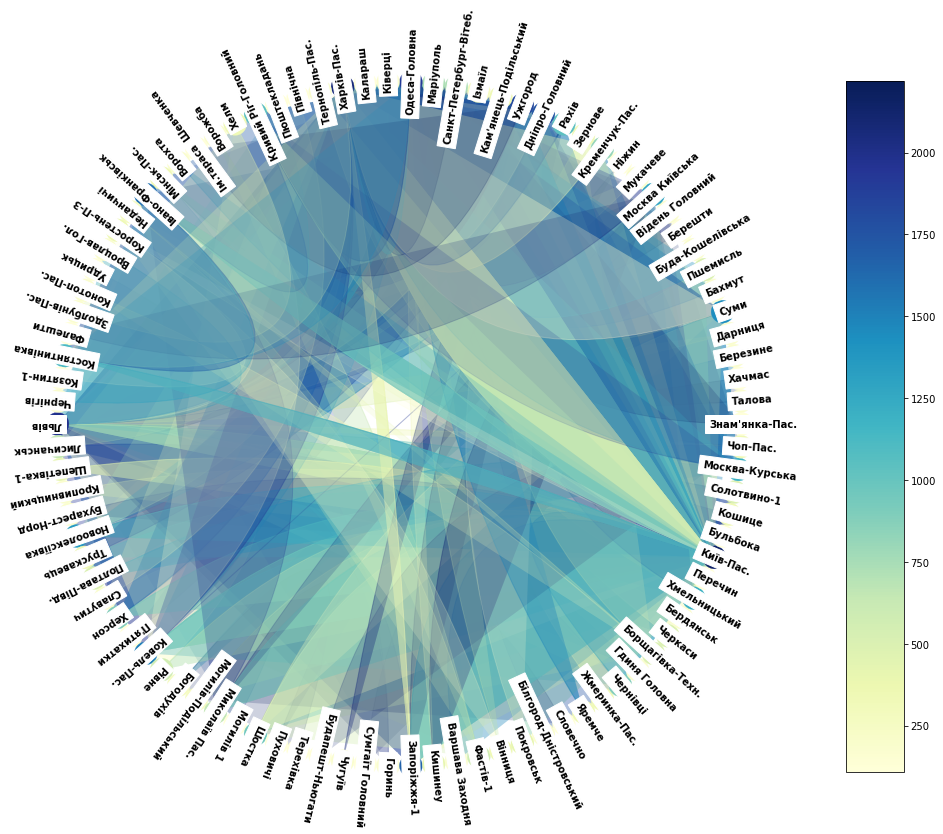

In [11]:
c = CircosPlot(G, node_labels=True, node_color='value', edge_color='travel_time')
c.draw()
plt.show()

In [12]:
from pylab import figure, axes, pie, title, show

# Make a square figure and axes
fig = figure(1, figsize=(6, 6))
c.draw()
fig.savefig('img.png')   # save the figure to file
plt.close(fig)   

C:\Users\Maksym\Anaconda3\envs\py35\lib\site-packages\matplotlib\patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
